In [1]:
import matplotlib.pyplot as plt
from math import ceil
import math
import numpy as np
import pandas as pd
import scipy.stats as stats

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold

# using statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm

%matplotlib inline
plt.style.use('ggplot')
from pandas.plotting import scatter_matrix
import pylab as py

### Import

In [2]:
loan_df = pd.read_csv('../data/intrest_rates.csv')

### Initial EDA

In [3]:
loan_df.head()

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length
0,8.90,735-739,20000,20000.0,36
1,12.12,715-719,19200,19200.0,36
2,21.98,690-694,35000,35000.0,60
3,9.99,695-699,10000,9975.0,36
4,11.71,695-699,12000,12000.0,36


In [4]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2498 entries, 0 to 2497
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   interest_rate               2498 non-null   float64
 1   fico_range                  2498 non-null   object 
 2   amount_requested            2498 non-null   int64  
 3   amount_funded_by_investors  2498 non-null   float64
 4   loan_length                 2498 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 97.7+ KB


In [5]:
loan_df.describe()

,interest_rate,amount_requested,amount_funded_by_investors,loan_length
count,2498.000000,2498.000000,2498.000000,2498.000000
mean,13.070368,12413.030424,12009.280661,41.265012
std,4.178007,7801.222483,7743.387861,9.933753
min,5.420000,1000.000000,-0.010000,36.000000
25%,10.160000,6000.000000,6000.000000,36.000000
50%,13.110000,10000.000000,10000.000000,36.000000
75%,15.800000,17000.000000,16000.000000,36.000000
max,24.890000,35000.000000,35000.000000,60.000000


In [6]:
loan_df['fico_range']

0       735-739
1       715-719
2       690-694
3       695-699
4       695-699
         ...   
2493    705-709
2494    740-744
2495    680-684
2496    675-679
2497    670-674
Name: fico_range, Length: 2498, dtype: object

In [7]:
fico = loan_df['fico_range'].str.findall('(\d+)')
fico

0       [735, 739]
1       [715, 719]
2       [690, 694]
3       [695, 699]
4       [695, 699]
           ...    
2493    [705, 709]
2494    [740, 744]
2495    [680, 684]
2496    [675, 679]
2497    [670, 674]
Name: fico_range, Length: 2498, dtype: object

In [8]:
fico_means = pd.Series([])
for i in range (0,len(fico)):
    fico[i] = np.array(fico[i]).astype(np.float64)
    fico_means[i] = sum(fico[i])/len(fico[i])
fico_means

C:\Users\RGBMonster\AppData\Local\Temp\ipykernel_8164\1568151351.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  fico_means = pd.Series([])


0       737.0
1       717.0
2       692.0
3       697.0
4       697.0
        ...  
2493    707.0
2494    742.0
2495    682.0
2496    677.0
2497    672.0
Length: 2498, dtype: float64

In [9]:
loan_df['fico_score'] = fico_means
loan_df

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_score
0,8.90,735-739,20000,20000.00,36,737.0
1,12.12,715-719,19200,19200.00,36,717.0
2,21.98,690-694,35000,35000.00,60,692.0
3,9.99,695-699,10000,9975.00,36,697.0
4,11.71,695-699,12000,12000.00,36,697.0
...,...,...,...,...,...,...
2493,16.77,705-709,30000,29950.00,60,707.0
2494,14.09,740-744,16000,16000.00,60,742.0
2495,13.99,680-684,10000,10000.00,36,682.0
2496,12.42,675-679,6000,6000.00,36,677.0


In [10]:
loan_df.replace({36:0,60:1},inplace=True)

In [11]:
# loan_df[loan_df['amount_funded_by_investors']<0]

In [12]:
loan_df.replace({-0.01:0},inplace=True)

In [13]:
loan_df.describe()

,interest_rate,amount_requested,amount_funded_by_investors,loan_length,fico_score
count,2498.000000,2498.000000,2498.000000,2498.000000,2498.000000
mean,13.070368,12413.030424,12009.280669,0.219376,707.858687
std,4.178007,7801.222483,7743.387848,0.413906,34.994039
min,5.420000,1000.000000,0.000000,0.000000,642.000000
25%,10.160000,6000.000000,6000.000000,0.000000,682.000000
50%,13.110000,10000.000000,10000.000000,0.000000,702.000000
75%,15.800000,17000.000000,16000.000000,0.000000,727.000000
max,24.890000,35000.000000,35000.000000,1.000000,832.000000


#### Loan Length; 0 equals 36 month term, 1 equals 60 month term

In [14]:
loan_df

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_score
0,8.90,735-739,20000,20000.00,0,737.0
1,12.12,715-719,19200,19200.00,0,717.0
2,21.98,690-694,35000,35000.00,1,692.0
3,9.99,695-699,10000,9975.00,0,697.0
4,11.71,695-699,12000,12000.00,0,697.0
...,...,...,...,...,...,...
2493,16.77,705-709,30000,29950.00,1,707.0
2494,14.09,740-744,16000,16000.00,1,742.0
2495,13.99,680-684,10000,10000.00,0,682.0
2496,12.42,675-679,6000,6000.00,0,677.0


array([[<Axes: xlabel='interest_rate', ylabel='interest_rate'>,
        <Axes: xlabel='amount_requested', ylabel='interest_rate'>,
        <Axes: xlabel='amount_funded_by_investors', ylabel='interest_rate'>,
        <Axes: xlabel='loan_length', ylabel='interest_rate'>,
        <Axes: xlabel='fico_score', ylabel='interest_rate'>],
       [<Axes: xlabel='interest_rate', ylabel='amount_requested'>,
        <Axes: xlabel='amount_requested', ylabel='amount_requested'>,
        <Axes: xlabel='amount_funded_by_investors', ylabel='amount_requested'>,
        <Axes: xlabel='loan_length', ylabel='amount_requested'>,
        <Axes: xlabel='fico_score', ylabel='amount_requested'>],
       [<Axes: xlabel='interest_rate', ylabel='amount_funded_by_investors'>,
        <Axes: xlabel='amount_requested', ylabel='amount_funded_by_investors'>,
        <Axes: xlabel='amount_funded_by_investors', ylabel='amount_funded_by_investors'>,
        <Axes: xlabel='loan_length', ylabel='amount_funded_by_investors'>,

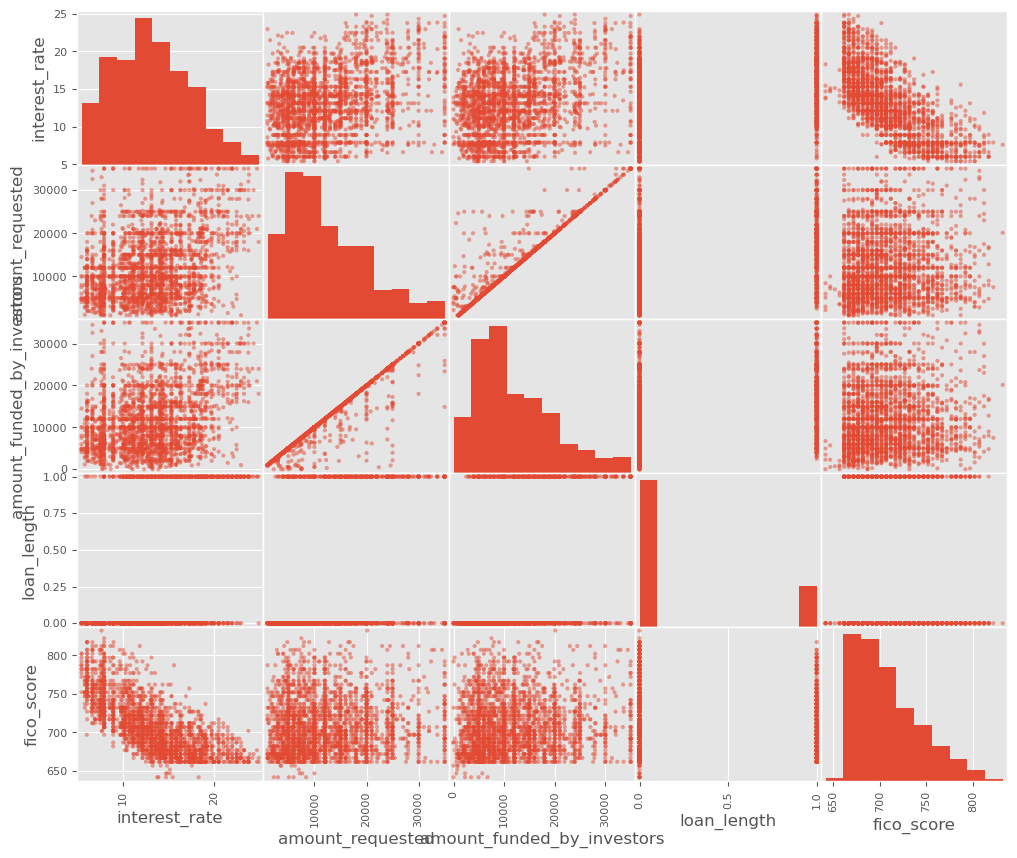

In [15]:
scatter_matrix(loan_df,figsize=(12,10))

In [16]:
loan_df.corr()

C:\Users\RGBMonster\AppData\Local\Temp\ipykernel_8164\804777513.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  loan_df.corr()


,interest_rate,amount_requested,amount_funded_by_investors,loan_length,fico_score
interest_rate,1.000000,0.331831,0.336830,0.423506,-0.709216
amount_requested,0.331831,1.000000,0.969841,0.412298,0.083378
amount_funded_by_investors,0.336830,0.969841,1.000000,0.406218,0.074284
loan_length,0.423506,0.412298,0.406218,1.000000,0.012703
fico_score,-0.709216,0.083378,0.074284,0.012703,1.000000


In [17]:
loan_df['funding_difference'] =  loan_df['amount_requested']- loan_df['amount_funded_by_investors']
loan_df

,interest_rate,fico_range,amount_requested,amount_funded_by_investors,loan_length,fico_score,funding_difference
0,8.90,735-739,20000,20000.00,0,737.0,0.00
1,12.12,715-719,19200,19200.00,0,717.0,0.00
2,21.98,690-694,35000,35000.00,1,692.0,0.00
3,9.99,695-699,10000,9975.00,0,697.0,25.00
4,11.71,695-699,12000,12000.00,0,697.0,0.00
...,...,...,...,...,...,...,...
2493,16.77,705-709,30000,29950.00,1,707.0,50.00
2494,14.09,740-744,16000,16000.00,1,742.0,0.00
2495,13.99,680-684,10000,10000.00,0,682.0,0.00
2496,12.42,675-679,6000,6000.00,0,677.0,0.00


### Initial Regression Analysis

In [18]:
X = loan_df[['amount_requested','funding_difference','loan_length','fico_score']]
# X = loan_df['amount_requested']
y = loan_df['interest_rate']

X = sm.add_constant(X)

simple_model = sm.OLS(y,X).fit()
simple_predictions = simple_model.predict(X)

print_simple_table = simple_model.summary()
print(print_simple_table)

                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     1833.
Date:                Thu, 26 Oct 2023   Prob (F-statistic):               0.00
Time:                        12:38:45   Log-Likelihood:                -5402.6
No. Observations:                2498   AIC:                         1.082e+04
Df Residuals:                    2493   BIC:                         1.084e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 72.6600      0

Standardized Summary

In [19]:
class XyScaler(BaseEstimator, TransformerMixin):
    """Standardize a training set of data along with a vector of targets."""

    def __init__(self):
        self.X_scaler = StandardScaler()
        
    def fit(self, X, *args, **kwargs):
        """Fit the scaler to data and a target vector."""
        self.X_scaler.fit(X)
        return self
    
    def transform(self, X, *args, **kwargs):
        """Transform a new set of data and target vector."""
        return (self.X_scaler.transform(X))

    def inverse_transform(self, X, *args, **kwargs):
        """Tranform from a scaled representation back to the original scale."""
        return (self.X_scaler.inverse_transform(X))

In [20]:
X

,const,amount_requested,funding_difference,loan_length,fico_score
0,1.0,20000,0.00,0,737.0
1,1.0,19200,0.00,0,717.0
2,1.0,35000,0.00,1,692.0
3,1.0,10000,25.00,0,697.0
4,1.0,12000,0.00,0,697.0
...,...,...,...,...,...
2493,1.0,30000,50.00,1,707.0
2494,1.0,16000,0.00,1,742.0
2495,1.0,10000,0.00,0,682.0
2496,1.0,6000,0.00,0,677.0


In [21]:
# df_scaler = XyScaler()
# df_scaler.fit(X)
# X_scaled = df_scaler.transform(X)
# X_scaled = pd.DataFrame(X_scaled, columns=['fico_score', 'amount_requested', 'loan_length', ''])
# X_scaled

In [22]:
# X_scaled = sm.add_constant(X_scaled)
# scaled_model = sm.OLS(y, X_scaled).fit()
# scaled_predictions = scaled_model.predict(X_scaled)

# print_scaled_table = scaled_model.summary()
# print(print_scaled_table)
# # X_scaled

In [23]:
X

,const,amount_requested,funding_difference,loan_length,fico_score
0,1.0,20000,0.00,0,737.0
1,1.0,19200,0.00,0,717.0
2,1.0,35000,0.00,1,692.0
3,1.0,10000,25.00,0,697.0
4,1.0,12000,0.00,0,697.0
...,...,...,...,...,...
2493,1.0,30000,50.00,1,707.0
2494,1.0,16000,0.00,1,742.0
2495,1.0,10000,0.00,0,682.0
2496,1.0,6000,0.00,0,677.0


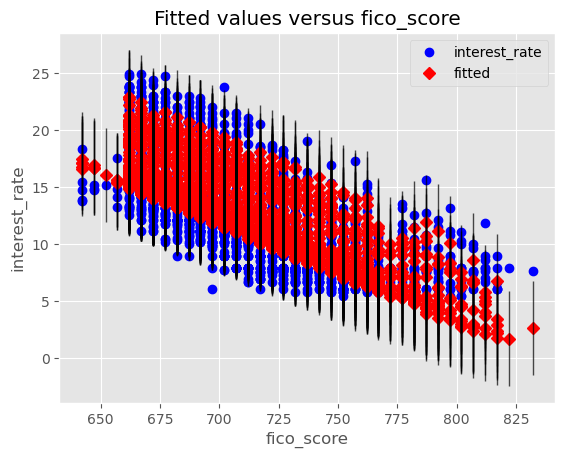

In [24]:
sm.graphics.plot_fit(simple_model,'fico_score');

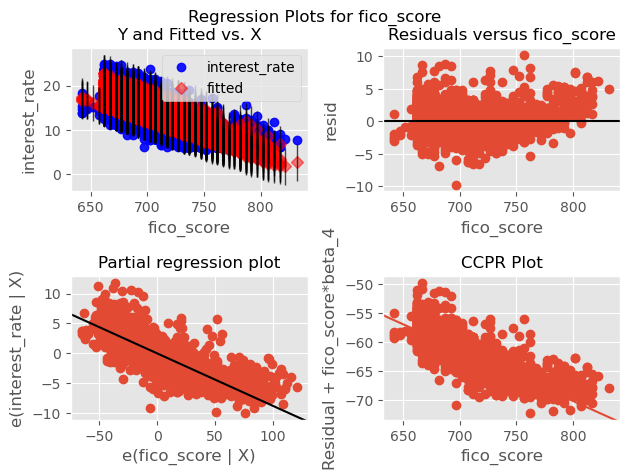

In [25]:
sm.graphics.plot_regress_exog(simple_model,'fico_score');

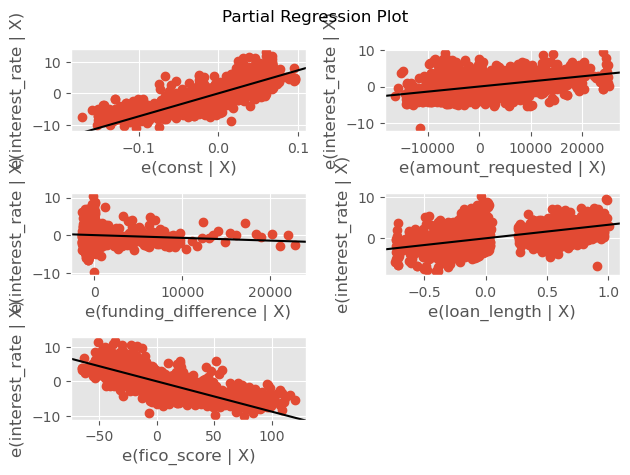

In [26]:
fig = sm.graphics.plot_partregress_grid(simple_model)
fig.tight_layout();

In [27]:
mean_squared_error(y,simple_predictions)

4.4268514918544355

In [28]:
loan_df['fico_score'].max()

832.0

In [29]:
loan_df['interest_rate'].max()

24.89

In [30]:
simple_predictions

0       10.899178
1       12.538799
2       20.247026
3       12.988503
4       13.273219
          ...    
2493    18.221578
2494    13.177788
2495    14.304922
2496    14.177365
2497    14.763102
Length: 2498, dtype: float64

In [31]:
loan_df['fico_score']
x = np.linspace(640,840,10)
pd.Series(x)

0    640.000000
1    662.222222
2    684.444444
3    706.666667
4    728.888889
5    751.111111
6    773.333333
7    795.555556
8    817.777778
9    840.000000
dtype: float64

In [32]:
x

array([640.        , 662.22222222, 684.44444444, 706.66666667,
       728.88888889, 751.11111111, 773.33333333, 795.55555556,
       817.77777778, 840.        ])

Text(0.5, 1.0, 'Fico Score and Interest Rate Given Other Influences')

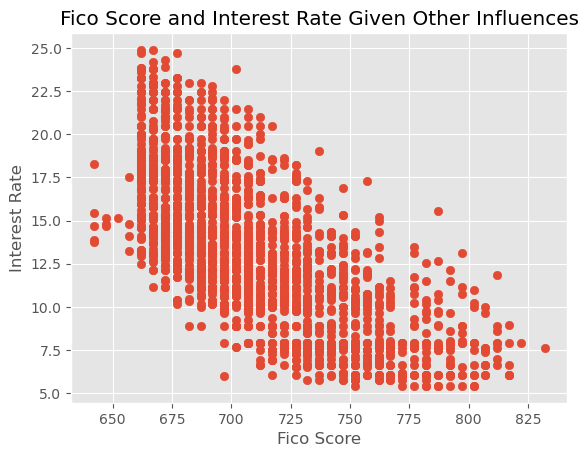

In [209]:
fig, ax = plt.subplots()

x = np.linspace(640,840,3000)

ax.scatter(np.array(loan_df['fico_score']),y=np.array(y))
ax.set_xlabel('Fico Score')
ax.set_ylabel('Interest Rate')
ax.set_title('Fico Score and Interest Rate Given Other Influences')


In [34]:
type(simple_predictions)

pandas.core.series.Series

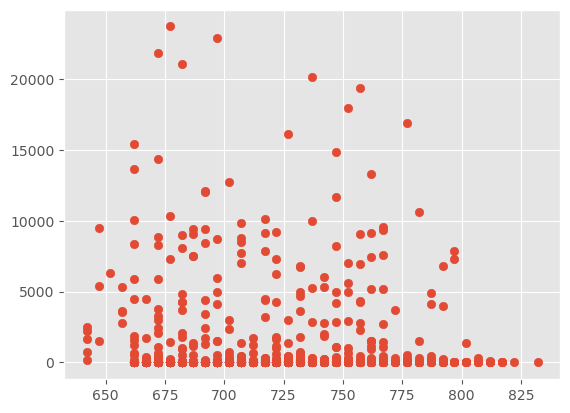

In [35]:
fig,ax = plt.subplots()

ax.scatter(loan_df['fico_score'],loan_df['funding_difference'])

Hypothesis

H0: Amount requested has greater impact on interest rate than fico score/loan term.

H1: Amount requested has <= fico score/loan term impact on interest rate.

Method 1:

X = fico score/loan term/amount requested

y = interest rate

Method 2:

X = fico score/loan term

y = interest rate

vs.

X = fico score/loan term/amount requested

y = interest rate

In [157]:
loan_df.head()

X = loan_df.loc[:, ['fico_score', 'amount_requested', 'loan_length']]
X

y = loan_df['interest_rate']
y

x_scale = XyScaler()
x_scale.fit(X)
X = x_scale.transform(X)
X = pd.DataFrame(X, columns=['fico_score', 'amount_requested', 'loan_length'])
X

,fico_score,amount_requested,loan_length
0,0.832918,0.972731,-0.530119
1,0.261277,0.870162,-0.530119
2,-0.453273,2.895891,1.886371
3,-0.310363,-0.309376,-0.530119
4,-0.310363,-0.052955,-0.530119
...,...,...,...
2493,-0.024543,2.254838,1.886371
2494,0.975828,0.459888,1.886371
2495,-0.739093,-0.309376,-0.530119
2496,-0.882004,-0.822219,-0.530119


In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [159]:
def cv(X, y, base_estimator=LinearRegression, alpha=1, n_folds=5):
  """
  Estimate the in- and out-of-sample error of a model using cross
  validation.
    
  Parameters
  ----------
      
  X: np.array
    Matrix of predictors.
        
  y: np.array
    Target array.
        
  base_estimator: sklearn model object.
    The estimator to fit.  Must have fit and predict methods. Name only, do not call.
        
  n_folds: int
    The number of folds in the cross validation.
      
  Returns
  -------
  test_cv_errors:
    The testing errors for each fold of cross validation.
  """
  if base_estimator == Ridge:
     reg = base_estimator(alpha=alpha)
  elif base_estimator == Lasso:
    reg = base_estimator(alpha=alpha)
  else:
     reg = base_estimator()
     
  kf = KFold(n_splits=n_folds)
  
  test_cv_errors = np.zeros(n_folds)

  i = 0
  for train_index, test_index in kf.split(X):

      X_train_fold, X_test_fold = X.iloc[train_index], X.iloc[test_index]
      y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
      
      model = reg.fit(X_train_fold,y_train_fold)
      results = model.predict(X_test_fold)
      mse = mean_squared_error(y_test_fold, results)
      test_cv_errors[i] = mse
      i+=1
  
  return test_cv_errors

In [160]:
def train_at_various_alphas(X, y, alphas, model=Ridge, n_folds=5):
    """
    Train a regularized regression model using cross 
    validation at various values of alpha.
    
    Parameters
    ----------
    
    X: np.array
      Matrix of predictors.
      
    y: np.array
      Target array.
      
    model: sklearn model class
      A class in sklearn that can be used to create a regularized regression
      object.  Options are `Ridge` and `Lasso`.
      
    alphas: numpy array
      An array of regularization parameters.
      
    n_folds: int
      Number of cross validation folds.
      
    Returns
    -------
    
    cv_errors_test:
      DataFrame containing the testing errors for each value of
      alpha and each cross validation fold.  Each row represents a CV fold, and
      each column a value of alpha.
      """
    cv_errors_test = pd.DataFrame(np.zeros(shape=(n_folds, len(alphas))),
                                        columns=alphas)
    
    i=0
    for alpha in alphas:
      alpha_result = cv(X, y, base_estimator=model, alpha=alpha, n_folds=n_folds)
      cv_errors_test.iloc[:, i] = alpha_result
      i+=1

    cv_errors_test.loc['mean'] = cv_errors_test.mean()

    return cv_errors_test

Training

In [161]:
# Training w/ linear regression
np.mean(cv(X_train, y_train))

4.473092851608977

4.4729823715458314

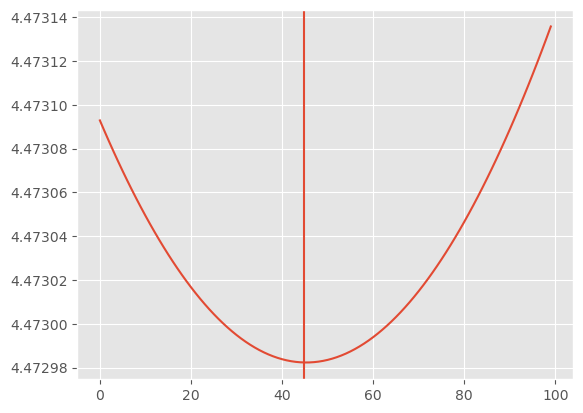

In [174]:
# Training w/ Ridge
ridge_alphas = np.arange(0,10,0.1)

training_ridge = train_at_various_alphas(X_train, y_train, ridge_alphas)

fig, ax = plt.subplots()

ax.plot(range(len(training_ridge.columns)), training_ridge.loc['mean'])
ax.axvline(np.min(training_ridge.loc['mean'])*10)
np.min(training_ridge.loc['mean'])

In [170]:
training_ridge[4.5]

0       4.115276
1       5.198300
2       4.551947
3       4.062064
4       4.437325
mean    4.472982
Name: 4.5, dtype: float64

In [164]:
training_ridge.loc[['mean'] ,training_ridge.loc['mean', :] == training_ridge.loc['mean', :].min()]

,4.5
mean,4.472982


In [165]:
# Training w/ Lasso
# lasso_alphas = np.arange(0,0.5,0.001)

# training_lasso = train_at_various_alphas(X_train, y_train, lasso_alphas, Lasso)

# fig, ax = plt.subplots()

# ax.plot(range(len(training_lasso.columns)), training_lasso.loc['mean'])
# # ax.set_xticks(np.arange(0,25,1), labels=training_ridge.columns)
# # ax.axvline(np.min(training_ridge.loc['mean']))
# np.mean(training_lasso.loc['mean'])

Testing

In [166]:
X_train
y_train

2280     9.07
1290     8.00
2050     7.49
1388    21.67
416     10.16
        ...  
668     18.25
1051    12.12
367      6.62
140      9.76
1785    10.74
Name: interest_rate, Length: 1873, dtype: float64

In [171]:
model = Ridge(alpha=4.5)
trained_model = model.fit(X_train, y_train)
trained_predictions = trained_model.predict(X_train)
trained_predictions

array([ 8.58536769,  6.32043864, 10.6891898 , ...,  9.04183735,
        9.84954733, 13.59437144])

In [172]:
trained_model.coef_

array([-3.05699288,  1.04714957,  1.3638013 ])

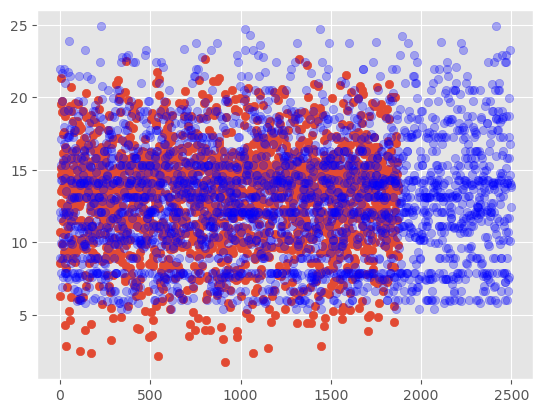

In [169]:
fig, ax = plt.subplots()

ax.scatter(range(0,1873),trained_predictions)
ax.scatter(range(0,2498), loan_df['interest_rate'], color='b', alpha=0.3)

Fico Score
***

In [175]:
Xfic = loan_df['fico_score']

Xfic

0       737.0
1       717.0
2       692.0
3       697.0
4       697.0
        ...  
2493    707.0
2494    742.0
2495    682.0
2496    677.0
2497    672.0
Name: fico_score, Length: 2498, dtype: float64

In [176]:
X_train, X_test, y_train, y_test = train_test_split(Xfic, y, test_size=0.25)

In [185]:
model = Ridge(alpha=4.5)
trained_model = model.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))
trained_predictions = trained_model.predict(np.array(X_train).reshape(-1,1))
trained_predictions

array([[11.83421354],
       [11.83421354],
       [ 8.4674643 ],
       ...,
       [16.46349376],
       [ 7.20493333],
       [12.2550572 ]])

Text(0.5, 1.0, 'Relationship Between Fico Score and Interest Rate')

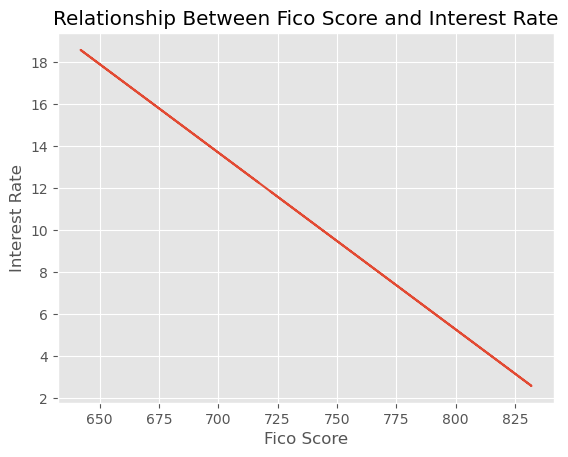

In [189]:
fig,ax = plt.subplots()
ax.plot(X_train, trained_predictions)
ax.set_xlabel('Fico Score')
ax.set_ylabel('Interest Rate')
ax.set_title('Relationship Between Fico Score and Interest Rate')

Loan Length
***

In [190]:
X_term = loan_df['loan_length']

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X_term, y, test_size=0.25)
np.array(X_train).reshape(-1,1)
np.array(y_train).reshape(-1,1)

array([[19.05],
       [17.04],
       [19.72],
       ...,
       [12.42],
       [12.23],
       [11.14]])

In [192]:
model = Ridge(alpha=4.5)
trained_model = model.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))
trained_predictions = trained_model.predict(np.array(X_train).reshape(-1,1))
trained_predictions

array([[16.21534052],
       [12.11480084],
       [16.21534052],
       ...,
       [12.11480084],
       [16.21534052],
       [12.11480084]])

Text(0.5, 1.0, 'Relationship Between Loan Term and Interest Rate')

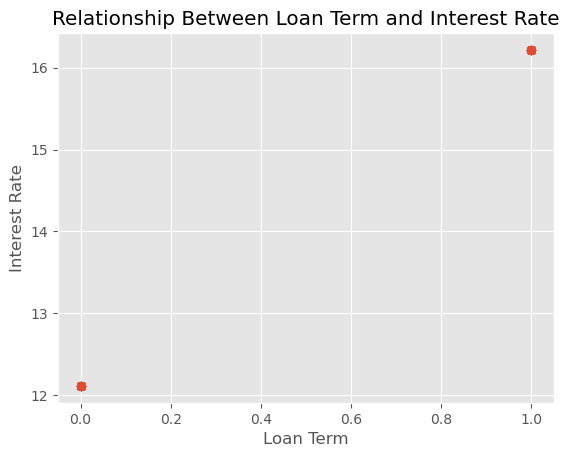

In [198]:
fig,ax = plt.subplots()
ax.scatter(X_train, trained_predictions)
ax.set_xlabel('Loan Term')
ax.set_ylabel('Interest Rate')
ax.set_title('Relationship Between Loan Term and Interest Rate')

Amount Requested
***

In [199]:
X_req = loan_df['amount_requested']

In [200]:
X_train, X_test, y_train, y_test = train_test_split(X_req, y, test_size=0.25)
np.array(X_train).reshape(-1,1)
np.array(y_train).reshape(-1,1)

array([[ 6.03],
       [15.31],
       [19.05],
       ...,
       [19.99],
       [11.99],
       [17.93]])

In [201]:
model = Ridge(alpha=4.5)
trained_model = model.fit(np.array(X_train).reshape(-1,1), np.array(y_train).reshape(-1,1))
trained_predictions = trained_model.predict(np.array(X_train).reshape(-1,1))
trained_predictions

array([[12.31411917],
       [11.39521801],
       [15.15435914],
       ...,
       [14.31899445],
       [11.39521801],
       [12.98241093]])

Text(0.5, 1.0, 'Relationship Between Amount Requested and Interest Rate')

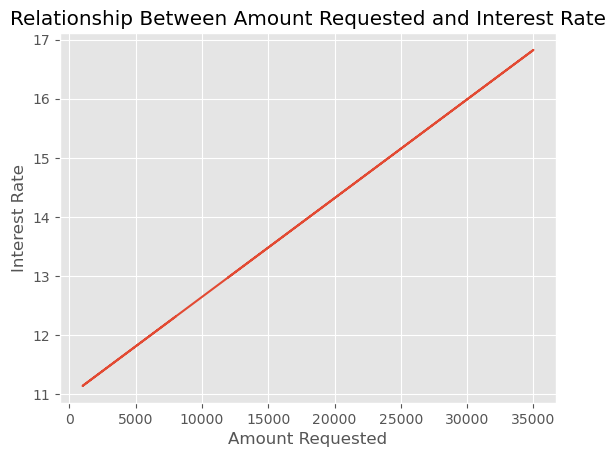

In [203]:
fig,ax = plt.subplots()
ax.plot(X_train, trained_predictions)
ax.set_xlabel('Amount Requested')
ax.set_ylabel('Interest Rate')
ax.set_title('Relationship Between Amount Requested and Interest Rate')